# Energy regression (calibration)
Compare different algorithm to calibrate the energy and check the performances

    This is not very different to what is done in ATLAS for electrons and photons

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

## Import the data

In [2]:
df_train = pd.read_csv('http://rgw.fisica.unimi.it/TutorialML-AtlasItalia2022/train_electron_Et0-10_eta1.0-1.2_Eaccordion.csv?AWSAccessKeyId=M06HBTUGIKXVXYH1RES6&Signature=U%2BMJxVi5El1wxtCz%2B45VqLmUuok%3D&Expires=1828739034')
df_test = pd.read_csv('http://rgw.fisica.unimi.it/TutorialML-AtlasItalia2022/test_electron_Et0-10_eta1.0-1.2_Eaccordion.csv?AWSAccessKeyId=M06HBTUGIKXVXYH1RES6&Signature=YKG4lzc%2FI0%2BcJZRnQG350DnVVK4%3D&Expires=1828739085')

#df_train = pd.read_csv('train_electron_Et0-10_eta1.0-1.2_Eaccordion.csv')
#df_test = pd.read_csv('test_electron_Et0-10_eta1.0-1.2_Eaccordion.csv')

df_train['el_rawcl_Es1Over2'] = df_train['el_rawcl_Es1'] / df_train['el_rawcl_Es2']
df_test['el_rawcl_Es1Over2'] = df_test['el_rawcl_Es1'] / df_test['el_rawcl_Es2']

## Normalize the data
Normalize the data such that the average of of each variable is 0 and the variance is 1

In [3]:
columns_X = ['el_rawcl_E', 'el_rawcl_Es1Over2', 'el_f0', 'el_cl_aeta', ]  # input variables
column_y = 'el_erawOverEtrue'  # this is the target

normalizer = tf.keras.layers.Normalization()
# this will take a while since it needs to read all your data and compute the mean and the variabnce
# normalization is non-trainable layer, it must be run before the training
normalizer.adapt(np.array(df_train[columns_X]))

### Check if the normalization works

In [4]:
print(tf.math.reduce_mean(normalizer(df_train[columns_X]), axis=0))
print(tf.math.reduce_variance(normalizer(df_train[columns_X]), axis=0))

tf.Tensor([ 2.3363230e-06 -2.1132200e-07 -1.3879234e-06 -2.3549543e-05], shape=(4,), dtype=float32)
tf.Tensor([0.999997   0.9999975  0.99999565 0.9999905 ], shape=(4,), dtype=float32)


## Define the model: linear regression
The output is just a linear combination of the inputs

$$\hat y = \sum_i w_i x_i + b$$

In [5]:
x_inputs = tf.keras.Input(shape=len(columns_X))
x = tf.keras.layers.Dense(units=1, activation=None, name='out_0')(x_inputs)

model_linear_regression = tf.keras.Model(x_inputs, x)

## Train

In [6]:
model_linear_regression.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0005),
                                loss='mean_absolute_error')

history = model_linear_regression.fit(
    normalizer(df_train[columns_X].values),
    df_train[column_y].values,
    batch_size=64,
    epochs=5,
    validation_split=0.2) # Calculate validation results on 20% of the training data.

# note that the normalization is applied here, and not inside the model.
# This is because of a limitation of lwtnn (see at the end)

Epoch 1/5
1144/1144 [==============================] - 3s 2ms/step - loss: 0.5560 - val_loss: 0.2826
Epoch 2/5
1144/1144 [==============================] - 2s 2ms/step - loss: 0.1193 - val_loss: 0.0670
Epoch 3/5
1144/1144 [==============================] - 2s 2ms/step - loss: 0.0671 - val_loss: 0.0671
Epoch 4/5
1144/1144 [==============================] - 2s 2ms/step - loss: 0.0671 - val_loss: 0.0671
Epoch 5/5
1144/1144 [==============================] - 2s 2ms/step - loss: 0.0672 - val_loss: 0.0670


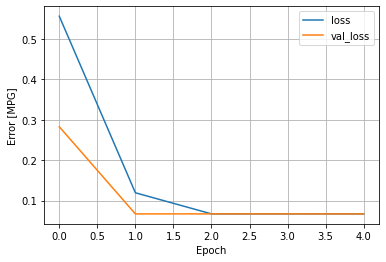

In [7]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

### Basically the linear regression is just shifting the response to 1
Dump the weights and the bias of the linear regression

In [8]:
for col, weight in zip(columns_X, model_linear_regression.layers[1].kernel):
    print("{:<20s} : {:+.3f}".format(col, weight.numpy()[0]))
print("bias                 : {:+.3f}".format(model_linear_regression.layers[1].bias.numpy()[0]))

el_rawcl_E           : +0.028
el_rawcl_Es1Over2    : -0.015
el_f0                : -0.009
el_cl_aeta           : -0.002
bias                 : +0.784


In fact the median is very close to the bias

In [9]:
df_train[column_y].median()

0.787762405

## Check performance with test sample
Compare the performance checking the $E/E_\text{true}$ distribution using different version of the $E$:

   * the raw energy
   * the raw energy scaled so that the median of $E/E_\text{true}$ is 1
   * the output of the trained algorithm
   
Take into account that if we scale the energy with a number $>1$ we will increase the variance.

In [10]:
df_test['E_linear_regression'] = df_test['el_rawcl_E'] / model_linear_regression.predict(normalizer(df_test[columns_X])).T[0] 

1225/1225 [==============================] - 2s 1ms/step


In [11]:
df_test['E_median_shifted'] = df_test['el_rawcl_E'] / df_test['el_erawOverEtrue'].median()

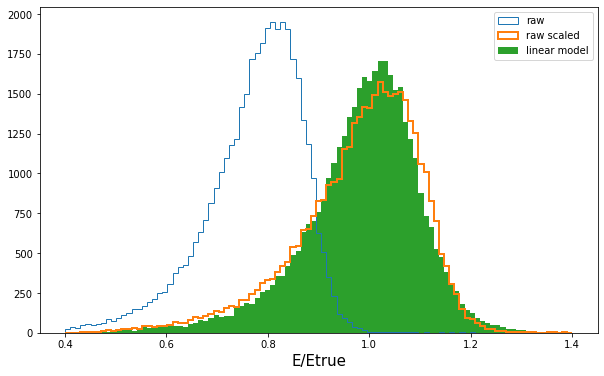

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
xspace = np.linspace(0.4, 1.4, 100)
ax.hist(df_test['el_rawcl_E'] / df_test['el_truth_E'], bins=xspace, label='raw', histtype='step')
ax.hist(df_test['E_median_shifted'] / df_test['el_truth_E']  , bins=xspace, label='raw scaled', histtype='step', lw=2)
ax.hist(df_test['E_linear_regression'] / df_test['el_truth_E'], bins=xspace, label='linear model', histtype='stepfilled')
ax.legend(loc=0)
ax.set_xlabel('E/Etrue', fontsize=15)
plt.show()

## Check the linearity as a function of input variables
If we are using all the information the ratio of E/Etrue should be 1 as a function of the input variables

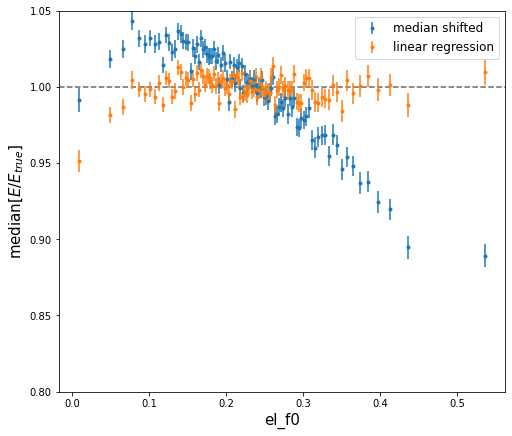

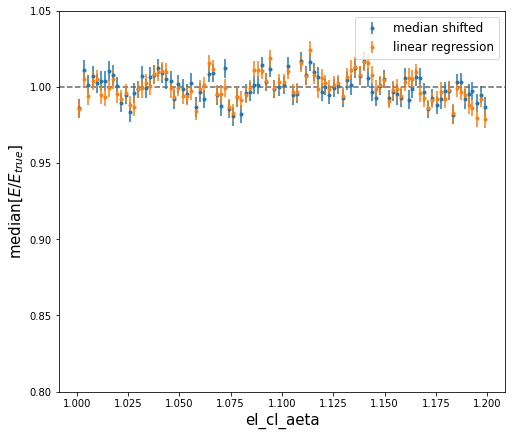

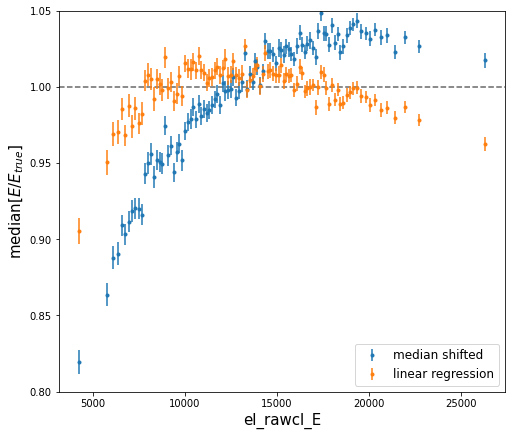

In [13]:
def get_profile(df, xvar, energy_var, xedges, estimators=('median', 'sem')):
    df_agg = df_test.groupby(np.digitize(df_test[xvar], xedges)).apply(
        # approximate the error of the median as the standard error on the mean (sem)
        lambda df: (df[energy_var] / df['el_truth_E']).apply(estimators))
    df_agg = df_agg.reindex(range(1, len(xedges)))
    xmidpoints = 0.5 * (xedges[1:] + xedges[:-1])
    df_agg.index = xmidpoints
    return df_agg

def plot_profile(ax, df_agg, **kwargs):
    ax.errorbar(df_agg.index, df_agg['median'], df_agg['sem'], **kwargs)

xvars = ['el_f0', 'el_cl_aeta', 'el_rawcl_E']
for xvar in xvars:
    xedges = df_test[xvar].quantile(np.linspace(0, 1, 100)).values
    df_agg_E_median_shifted = get_profile(df_test, xvar, 'E_median_shifted', xedges)
    df_agg_E_linear_regression = get_profile(df_test, xvar, 'E_linear_regression', xedges)


    fig, ax = plt.subplots(figsize=(8, 7))
    plot_profile(ax, df_agg_E_median_shifted, fmt='.', label='median shifted')
    plot_profile(ax, df_agg_E_linear_regression, fmt='.', label='linear regression')
    ax.set_xlabel(xvar, fontsize=15)
    ax.set_ylabel(r'$\mathrm{median}[E / E_{true}]$', fontsize=15)
    ax.set_ylim(0.8, 1.05)
    ax.legend(loc=0, fontsize=12)
    ax.axhline(1, ls='--', color='0.4', zorder=-1)

## Redo with a 2 layers NN (2LNN)

In [14]:
model_2LNN = tf.keras.Sequential([
    tf.keras.Input(shape=len(columns_X)),
    normalizer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation=None),
])

In [15]:
model_2LNN.compile(optimizer=tf.optimizers.Adam(learning_rate=0.005), loss='mean_absolute_error')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model_2LNN.fit(df_train[columns_X].values, df_train[column_y].values,
                         epochs=20, verbose=True, batch_size=1024, validation_split=0.2, callbacks=[callback])

Epoch 1/20
72/72 [==============================] - 1s 10ms/step - loss: 0.2364 - val_loss: 0.5240
Epoch 2/20
72/72 [==============================] - 1s 9ms/step - loss: 0.0999 - val_loss: 0.3454
Epoch 3/20
72/72 [==============================] - 1s 8ms/step - loss: 0.0858 - val_loss: 0.1862
Epoch 4/20
72/72 [==============================] - 0s 6ms/step - loss: 0.0772 - val_loss: 0.1082
Epoch 5/20
72/72 [==============================] - 0s 6ms/step - loss: 0.0726 - val_loss: 0.0745
Epoch 6/20
72/72 [==============================] - 0s 6ms/step - loss: 0.0697 - val_loss: 0.0684
Epoch 7/20
72/72 [==============================] - 0s 7ms/step - loss: 0.0678 - val_loss: 0.0679
Epoch 8/20
72/72 [==============================] - 0s 6ms/step - loss: 0.0672 - val_loss: 0.0675
Epoch 9/20
72/72 [==============================] - 0s 6ms/step - loss: 0.0672 - val_loss: 0.0671
Epoch 10/20
72/72 [==============================] - 0s 6ms/step - loss: 0.0669 - val_loss: 0.0665
Epoch 11/20
72/72 

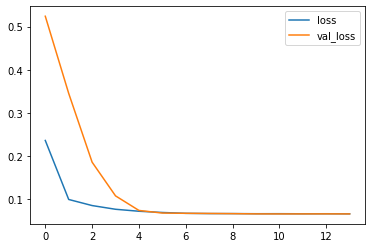

In [16]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [17]:
df_test['E_2LNN'] = df_test['el_rawcl_E'] / model_2LNN.predict(df_test[columns_X]).T[0] 

1225/1225 [==============================] - 2s 1ms/step


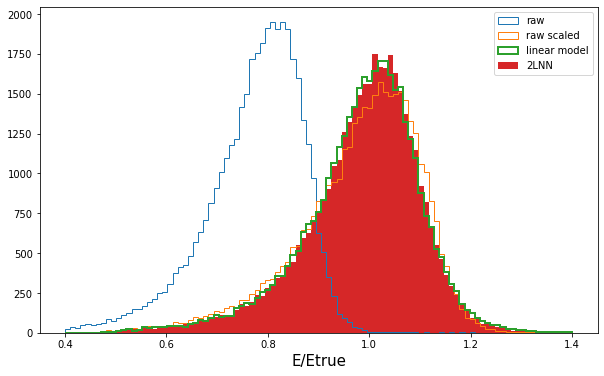

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
xspace = np.linspace(0.4, 1.4, 100)
ax.hist(df_test['el_rawcl_E'] / df_test['el_truth_E'], bins=xspace, label='raw', histtype='step')
ax.hist(df_test['E_median_shifted'] / df_test['el_truth_E']  , bins=xspace, label='raw scaled', histtype='step')
ax.hist(df_test['E_linear_regression'] / df_test['el_truth_E'], bins=xspace, label='linear model', histtype='step', lw=2)
ax.hist(df_test['E_2LNN'] / df_test['el_truth_E'], bins=xspace, label='2LNN', histtype='stepfilled')

ax.legend(loc=0)
ax.set_xlabel('E/Etrue', fontsize=15)
plt.show()

## Repeat with lightgbm (BDT)

In [19]:
import lightgbm as lgb

params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "l1",
    "metric": ["l2", "l1", "huber"],
    "num_leaves": 60,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "num_boost_round": 100,
}

lgb_train = lgb.Dataset(df_train[columns_X], df_train[column_y])
lgb_eval = lgb.Dataset(df_test[columns_X], df_test[column_y], reference=lgb_train)

model_lgbm = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 callbacks=[lgb.early_stopping(5), lgb.log_evaluation(10)])

/home/turra/venv3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 91464, number of used features: 4
[LightGBM] [Info] Start training from score 0.787763
Training until validation scores don't improve for 5 rounds
[10]	valid_0's l2: 0.00848353	valid_0's l1: 0.0689119	valid_0's huber: 0.00424176
[20]	valid_0's l2: 0.00808062	valid_0's l1: 0.0672332	valid_0's huber: 0.00404031
[30]	valid_0's l2: 0.00791924	valid_0's l1: 0.0665684	valid_0's huber: 0.00395962
[40]	valid_0's l2: 0.00785179	valid_0's l1: 0.0663078	valid_0's huber: 0.00392589
[50]	valid_0's l2: 0.0078155	valid_0's l1: 0.0661852	valid_0's huber: 0.00390775
[60]	valid_0's l2: 0.00779117	valid_0's l1: 0.0661261	valid_0's huber: 0.00389558
[70]	valid_0's l2: 0.00777903	valid_0's l1: 0.0661012	valid_0's huber: 0.00388951
[80]	valid_0's l2: 0.00

In [20]:
df_test['E_BDT'] = df_test['el_rawcl_E'] / model_lgbm.predict(df_test[columns_X])

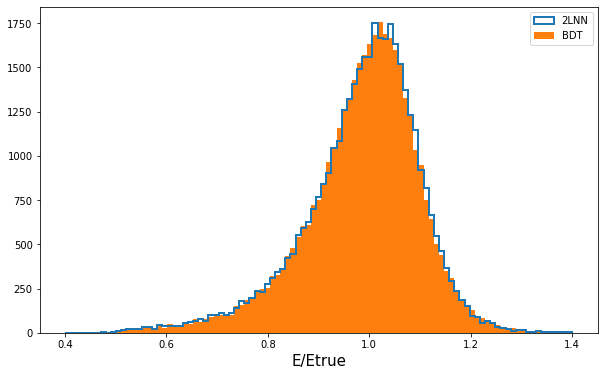

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
xspace = np.linspace(0.4, 1.4, 100)
ax.hist(df_test['E_2LNN'] / df_test['el_truth_E'], bins=xspace, label='2LNN', histtype='step', lw=2)
ax.hist(df_test['E_BDT'] / df_test['el_truth_E'], bins=xspace, label='BDT', histtype='stepfilled')

ax.legend(loc=0)
ax.set_xlabel('E/Etrue', fontsize=15)
plt.show()

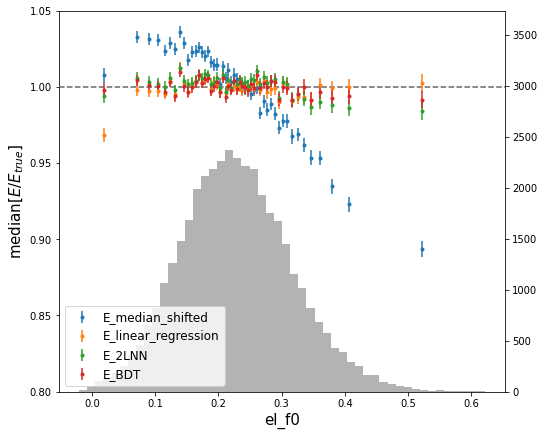

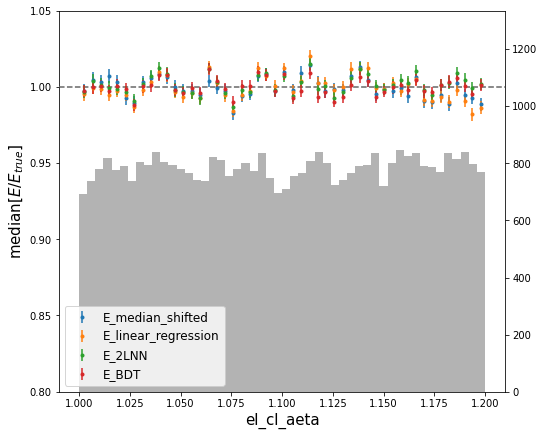

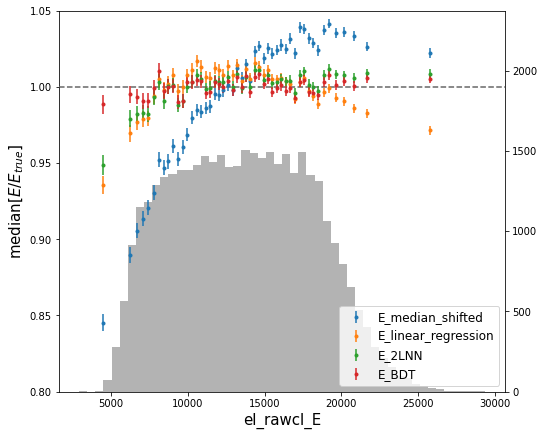

In [22]:
xvars = ['el_f0', 'el_cl_aeta', 'el_rawcl_E']
for xvar in xvars:
    fig, ax = plt.subplots(figsize=(8, 7))
    ax2 = ax.twinx()
    ax2.hist(df_test[xvar], 50, color='0.7')
    ax2.set_ylim(0, ax2.get_ylim()[1] * 1.5)
    

    xedges = df_test[xvar].quantile(np.linspace(0, 1, 50)).values
    for calibration in 'E_median_shifted', 'E_linear_regression', 'E_2LNN', 'E_BDT':
        df_agg = get_profile(df_test, xvar, calibration, xedges)    
        plot_profile(ax, df_agg, fmt='.', label=calibration)
    ax.set_xlabel(xvar, fontsize=15)
    ax.set_ylabel(r'$\mathrm{median}[E / E_{true}]$', fontsize=15)
    ax.set_ylim(0.8, 1.05)
    ax.legend(loc=0, fontsize=12)
    ax.axhline(1, ls='--', color='0.4', zorder=-1)
    
    ax.set_zorder(ax2.get_zorder() + 1)
    ax.set_frame_on(False)

The model which are able to use most of the information are the 2LNN and the BDT (very visible in the last plot where the linear regression is not flat)

## E/Etrue for different values of raw energy

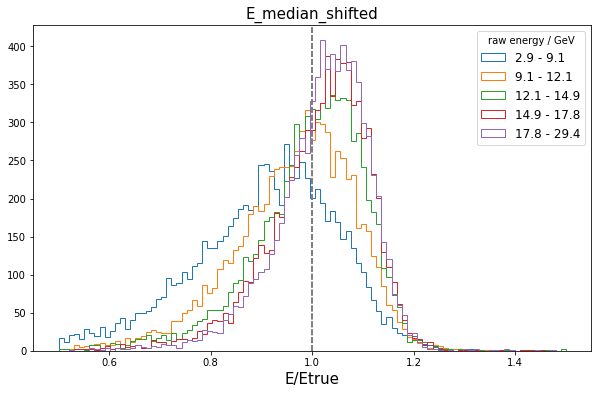

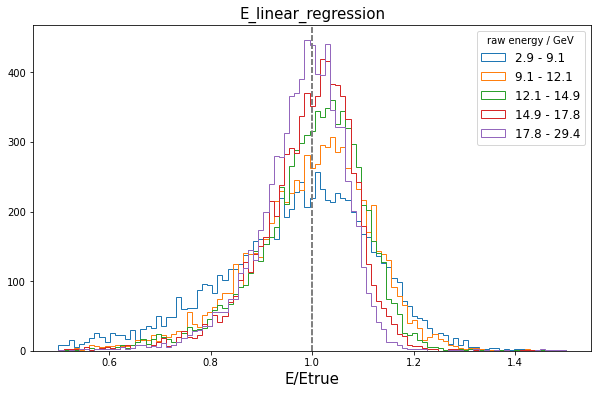

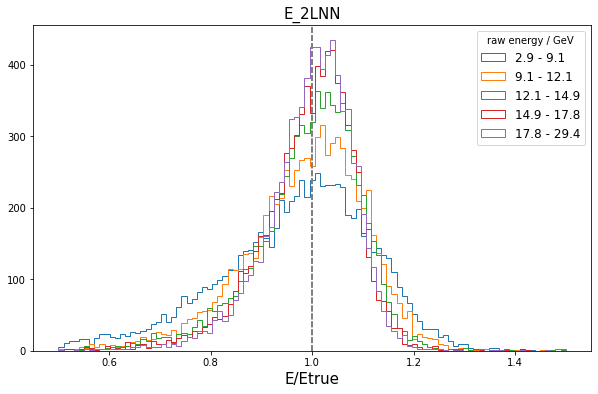

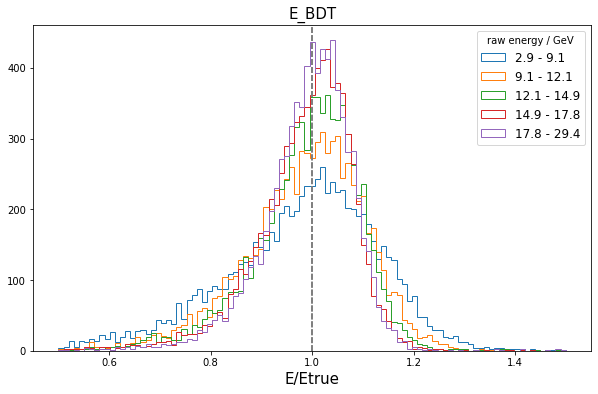

In [23]:
from itertools import tee

def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

el_rawcl_E_edges = df_test['el_rawcl_E'].quantile(np.linspace(0, 1, 5 + 1)).values

for calibration in 'E_median_shifted', 'E_linear_regression', 'E_2LNN', 'E_BDT':

    fig, ax = plt.subplots(figsize=(10, 6))
    xspace = np.linspace(0.5, 1.5, 100)
    for eraw_min, eraw_max in pairwise(el_rawcl_E_edges):
        mask = (df_test['el_rawcl_E'] >= eraw_min) & (df_test['el_rawcl_E'] < eraw_max)
        ax.hist(df_test[mask].eval(f'{calibration} / el_truth_E'),
                bins=xspace, label='%.1f - %.1f' % (eraw_min / 1E3, eraw_max / 1E3), histtype='step')
        ax.axvline(1, ls='--', color='0.5')
        ax.set_title(calibration, fontsize=15)

    ax.legend(loc=0, title='raw energy / GeV', fontsize=12)
    ax.set_xlabel('E/Etrue', fontsize=15)
    plt.show()

## Save the model with lwtnn to be used in Athena

In [24]:
# lwtnn does not support normalization layers

# 1) we need to write the model structure to json
# get the architecture as a json string
arch = model_linear_regression.to_json(indent=2)
print("== 1. architecture.json == ")
print(arch)
# save the architecture string to a file somehow, the below will work
with open('architecture.json', 'w') as arch_file:
    arch_file.write(arch)

# 2) save the weights as an HDF5 file
print("\n== 2. weights ==")
print(model_linear_regression.weights)
model_linear_regression.save_weights('weights.h5')

# 3) we need write an additional json file with the list of input variables
# lwtnn support simple normalization preprocessing, we need to specify it manually
import json
variables_json = []
for column, scale, offset in zip(columns_X, normalizer.mean.numpy()[0], normalizer.variance.numpy()[0]):
    variables_json.append({'name': column, 'offset': float(offset), 'scale': float(scale)})
data_variables = {"inputs": [{"name": "node0", "variables": variables_json}]}
data_variables["input_sequences"] = []
data_variables["outputs"] = [
    {
      "labels": [
        "out_0"
      ],
      "name": "output"
    }
  ]

print("\n== 3. input variables ==")
from pprint import pprint
pprint(data_variables)


json.dump(data_variables, open('variables.json', 'w'))

== 1. architecture.json == 
{
  "class_name": "Functional",
  "config": {
    "name": "model",
    "layers": [
      {
        "class_name": "InputLayer",
        "config": {
          "batch_input_shape": [
            null,
            4
          ],
          "dtype": "float32",
          "sparse": false,
          "ragged": false,
          "name": "input_1"
        },
        "name": "input_1",
        "inbound_nodes": []
      },
      {
        "class_name": "Dense",
        "config": {
          "name": "out_0",
          "trainable": true,
          "dtype": "float32",
          "units": 1,
          "activation": "linear",
          "use_bias": true,
          "kernel_initializer": {
            "class_name": "GlorotUniform",
            "config": {
              "seed": null
            }
          },
          "bias_initializer": {
            "class_name": "Zeros",
            "config": {}
          },
          "kernel_regularizer": null,
          "bias_regularizer": nul

In [25]:
# convert all the produced file to a single final json to be used inside Athena with lwtnn
!~/lwtnn/converters/kerasfunc2json.py architecture.json weights.h5 variables.json > model_lwtnn.json

lwtnn converter being configured for keras (v2.9).


In [26]:
!cat model_lwtnn.json

{
  "input_sequences": [],
  "inputs": [
    {
      "name": "node0",
      "variables": [
        {
          "name": "el_rawcl_E",
          "offset": 19980382.0,
          "scale": 13578.8818359375
        },
        {
          "name": "el_rawcl_Es1Over2",
          "offset": 0.08416920155286789,
          "scale": 0.7662401795387268
        },
        {
          "name": "el_f0",
          "offset": 0.007670518476516008,
          "scale": 0.22781488299369812
        },
        {
          "name": "el_cl_aeta",
          "offset": 0.0033332693856209517,
          "scale": 1.1008269786834717
        }
      ]
    }
  ],
  "layers": [
    {
      "activation": "linear",
      "architecture": "dense",
      "bias": [
        0.7836830019950867
      ],
      "weights": [
        0.027767468243837357,
        -0.015214943327009678,
        -0.008833886124193668,
        -0.002326110377907753
      ]
    }
  ],
  "nodes": [
    {
      "size": 4,
      "sources": [
        0
      ],
 

### Test with random inputs

In [27]:
!~/lwtnn/build/bin/lwtnn-test-lightweight-graph model_lwtnn.json

output:
out_0 0.755716


## Onnx and Sofie
lwtnn is very simple, a more advanced tool is ONNX. In TMVA the project [Sofie](https://indico.fnal.gov/event/23628/contributions/237964/attachments/154980/201725/TMVA_SOFIE_ROOTWS_May2022%20.pdf) can convert ONNX model to C++ code.